In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimq
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_clients = 100
E = 2
mnist_B = 50
cifar_B = 50
mnist_iid_lr = 0.215
mnist_niid_lr = 0.1

cifar10_lr = 0.15
rounds = 5
clients_per_round = 10
num_shards = 200
shard_size = 300
shards_per_client = 2

"""
 __  __ _   _ ___ ____ _____    ____ _   _ _   _ 
|  \/  | \ | |_ _/ ___|_   _|  / ___| \ | | \ | |
| |\/| |  \| || |\___ \ | |   | |   |  \| |  \| |
| |  | | |\  || | ___) || |   | |___| |\  | |\  |
|_|  |_|_| \_|___|____/ |_|    \____|_| \_|_| \_|
"""

class mnistCNN(nn.Module):
    def __init__(self):
        super(mnistCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layer
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        # Output layer
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Convolutional layer 1 with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Convolutional layer 2 with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output for the fully connected layer
        x = x.view(-1, 64 * 4 * 4)
        # Fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Output layer with softmax activation
        x = F.softmax(self.fc2(x), dim=1)
        return x

"""
  ____ ___ _____ _    ____     ____ _   _ _   _ 
 / ___|_ _|  ___/ \  |  _ \   / ___| \ | | \ | |
| |    | || |_ / _ \ | |_) | | |   |  \| |  \| |
| |___ | ||  _/ ___ \|  _ <  | |___| |\  | |\  |
 \____|___|_|/_/   \_\_| \_\  \____|_| \_|_| \_|
"""

class CIFARCNN(nn.Module):
    def __init__(self):
        super(CIFARCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  
        x = self.pool(x)  
        x = F.relu(self.conv2(x))  
        x = self.pool(x)  
        x = F.relu(self.conv3(x))  
        x = self.pool(x)
        x = self.flatten(x)  # Flatten the output
        x = F.relu(self.fc1(x))  # Apply dense layer with relu activation
        x = self.fc2(x)  # Apply final dense layer
        return x


"""
 ____        _          _                    _               
|  _ \  __ _| |_ __ _  | |    ___   __ _  __| | ___ _ __ ___ 
| | | |/ _` | __/ _` | | |   / _ \ / _` |/ _` |/ _ \ '__/ __|
| |_| | (_| | || (_| | | |__| (_) | (_| | (_| |  __/ |  \__ \
|____/ \__,_|\__\__,_| |_____\___/ \__,_|\__,_|\___|_|  |___/
"""
 
 # IID MNIST Loader
def iid_mnist_loader():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    traindata = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    traindata_split = torch.utils.data.random_split(traindata, [len(traindata) // num_clients for _ in range(num_clients)])
    train_loader = [DataLoader(x, batch_size=mnist_B, shuffle=True) for x in traindata_split]
    test_loader = DataLoader(datasets.MNIST(root='./data', train=False, download=True, transform=transform), batch_size=mnist_B, shuffle=False)
    return train_loader, test_loader

# Non-IID MNIST Loader
def non_iid_mnist_loader():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    traindata = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    # Sort the train data by digit label
    traindata.targets.sort()
    #Split the data into num_shards shards of shard_size samples each
    shards = [torch.utils.data.Subset(traindata, range(i*shard_size, (i+1)*shard_size)) for i in range(num_shards)]
    # Assign shards to clients
    client_dict = {i: [] for i in range(num_clients)}
    for i in range(num_shards):
        client_dict[i % num_clients].append(shards[i])
    # Create data loaders for each client
    train_loader = [DataLoader(torch.utils.data.ConcatDataset(client_dict[i]), batch_size=mnist_B, shuffle=True) for i in range(num_clients)]

    test_loader = DataLoader(datasets.MNIST(root='./data', train=False, download=True, transform=transform), batch_size=mnist_B, shuffle=False)
    return train_loader, test_loader

# CIFAR-10 Loader
def cifar_loader():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    traindata = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    traindata_split = torch.utils.data.random_split(traindata, [len(traindata) // num_clients for _ in range(num_clients)])
    train_loader = [DataLoader(x, batch_size=cifar_B, shuffle=True) for x in traindata_split]
    test_loader = DataLoader(datasets.CIFAR10(root='./data', train=False, download=True, transform=transform), batch_size=cifar_B, shuffle=False)
    return train_loader, test_loader

"""
 ___       _ _   _       _ _          _   _             
|_ _|_ __ (_) |_(_) __ _| (_)______ _| |_(_) ___  _ __  
 | || '_ \| | __| |/ _` | | |_  / _` | __| |/ _ \| '_ \ 
 | || | | | | |_| | (_| | | |/ / (_| | |_| | (_) | | | |
|___|_| |_|_|\__|_|\__,_|_|_/___\__,_|\__|_|\___/|_| |_|
"""

def mnist_iid_initialization():
    client_dict = dict()

    global_model = mnistCNN().to(device)
    client_models = [mnistCNN().to(device) for _ in range(num_clients)]

    for model in client_models:
        model.load_state_dict(global_model.state_dict())
    client_optimizers = [optimq.SGD(model.parameters(), lr=mnist_iid_lr) for model in client_models]
    return global_model, client_dict, client_optimizers, client_models

def mnist_non_iid_initialization():
    client_dict = dict()

    global_model = mnistCNN().to(device)
    client_models = [mnistCNN().to(device) for _ in range(num_clients)]

    for model in client_models:
        model.load_state_dict(global_model.state_dict())
    client_optimizers = [optimq.SGD(model.parameters(), lr=mnist_niid_lr) for model in client_models]
    return global_model, client_dict, client_optimizers, client_models

def cifar_initialization():
    client_dict = dict()

    global_model = CIFARCNN().to(device)
    client_models = [CIFARCNN().to(device) for _ in range(num_clients)]

    for model in client_models:
        model.load_state_dict(global_model.state_dict())
    client_optimizers = [optimq.SGD(model.parameters(), lr=cifar10_lr) for model in client_models]
    return global_model, client_dict, client_optimizers, client_models

"""
 _____ _       _____                 _   _                 
|  ___| |     |  ___|   _ _ __   ___| |_(_) ___  _ __  ___ 
| |_  | |     | |_ | | | | '_ \ / __| __| |/ _ \| '_ \/ __|
|  _| | |___  |  _|| |_| | | | | (__| |_| | (_) | | | \__ \
|_|   |_____| |_|   \__,_|_| |_|\___|\__|_|\___/|_| |_|___/
"""

def server_average(selected_cleints, global_model):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in selected_cleints], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

def train_client(client_id, epochs):
    model = client_models[client_id]
    model.train()
    train_loader_client = train_loader[client_id]
    optimizer = client_optimizers[client_id]
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader_client):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
    return model.state_dict()

def test_global(global_model, test_loader):
    global_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = global_model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    return test_loss, accuracy

def run_fl():
    global_losses = []
    global_accuracies = []
    for r in range(rounds):
        selected_clients = np.random.choice(range(num_clients), clients_per_round, replace=False)
        for client_id in selected_clients:
            client_dict[client_id] = train_client(client_id, E)
        server_average(selected_clients, global_model)
        test_loss, accuracy = test_global(global_model, test_loader)
        global_losses.append(test_loss)
        global_accuracies.append(accuracy)
        print(f'Round: {r}, Test Loss: {test_loss}, Accuracy: {accuracy}')

    return global_losses, global_accuracies

def run_fl_ABS():
    global_losses = []
    global_accuracies = []
    client_ages = np.zeros(num_clients)

    for r in range(rounds):
        oldest_client_idx = np.argsort(client_ages)[-clients_per_round:]
        client_ages += 1
        client_ages[oldest_client_idx] = 0
        selected_clients = oldest_client_idx
        for client_id in selected_clients:
            client_dict[client_id] = train_client(client_id, E)
        server_average(selected_clients, global_model)
        test_loss, accuracy = test_global(global_model, test_loader)
        global_losses.append(test_loss)
        global_accuracies.append(accuracy)
        print(f'Round: {r}, Test Loss: {test_loss}, Accuracy: {accuracy}')

    return global_losses, global_accuracies

train_loader, test_loader = iid_mnist_loader()
global_model, client_dict, client_optimizers, client_models = mnist_non_iid_initialization()
mnist_global_losses_niid, mnist_global_accuracies_niid = run_fl()

train_loader, test_loader = non_iid_mnist_loader()
global_model, client_dict, client_optimizers, client_models = mnist_iid_initialization()
mnist_global_losses_iid, mnist_global_accuracies_iid = run_fl()

train_loader, test_loader = cifar_loader()
global_model, client_dict, client_optimizers, client_models = cifar_initialization()
cifar_global_losses, cifar_global_accuracies = run_fl()

train_loader, test_loader = iid_mnist_loader()
global_model, client_dict, client_optimizers, client_models = mnist_iid_initialization()


Round: 0, Test Loss: 2.2811916709899904, Accuracy: 0.2579
Round: 1, Test Loss: 2.1225952613830565, Accuracy: 0.4644
Round: 2, Test Loss: 1.825548976135254, Accuracy: 0.6967
Round: 3, Test Loss: 1.746678670501709, Accuracy: 0.7323
Round: 4, Test Loss: 1.6393295936584473, Accuracy: 0.8584
Round: 0, Test Loss: 2.1634721725463866, Accuracy: 0.607
Round: 1, Test Loss: 1.8012583183288575, Accuracy: 0.6644
Round: 2, Test Loss: 1.6882339248657225, Accuracy: 0.7895
Round: 3, Test Loss: 1.5825351585388183, Accuracy: 0.8959
Round: 4, Test Loss: 1.5634936744689942, Accuracy: 0.9076
Files already downloaded and verified
Files already downloaded and verified
Round: 0, Test Loss: 2.295422698974609, Accuracy: 0.1362
Round: 1, Test Loss: 2.2694846656799315, Accuracy: 0.2108
Round: 2, Test Loss: 2.126283109283447, Accuracy: 0.2614
Round: 3, Test Loss: 2.034386855316162, Accuracy: 0.2931
Round: 4, Test Loss: 1.975019026184082, Accuracy: 0.2949


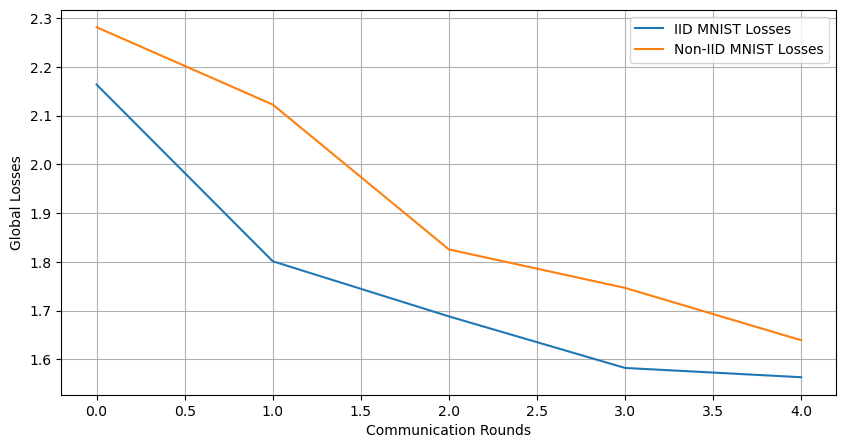

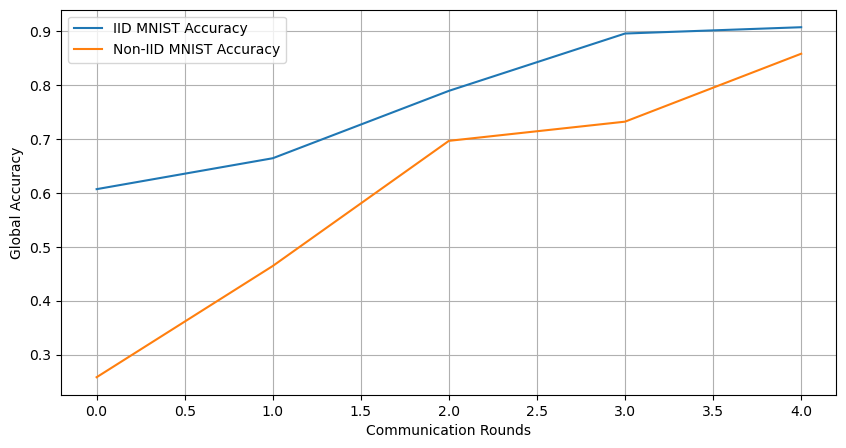

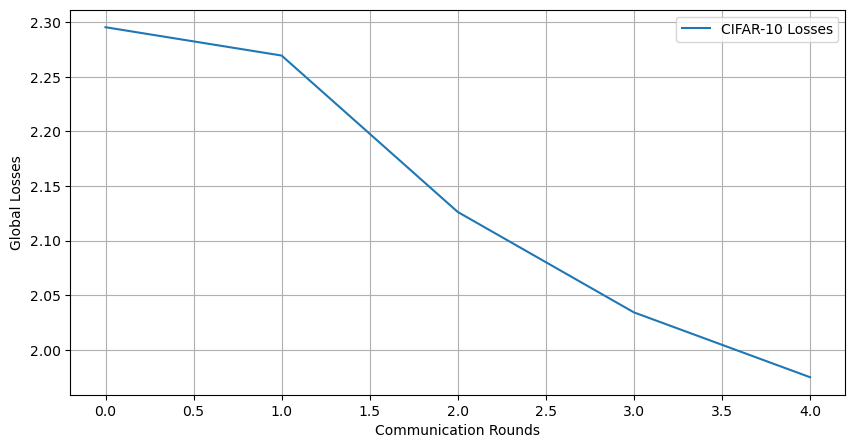

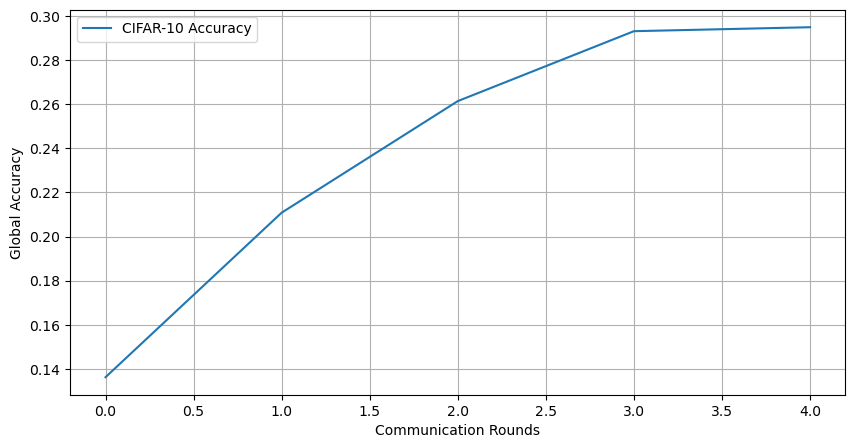

In [2]:
plt.figure(figsize=(10, 5))
plt.plot(mnist_global_losses_iid, label='IID MNIST Losses')
plt.plot(mnist_global_losses_niid, label='Non-IID MNIST Losses')
plt.xlabel('Communication Rounds')
plt.ylabel('Global Losses')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mnist_global_accuracies_iid, label='IID MNIST Accuracy')
plt.plot(mnist_global_accuracies_niid, label='Non-IID MNIST Accuracy')
plt.xlabel('Communication Rounds')
plt.ylabel('Global Accuracy')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(cifar_global_losses, label='CIFAR-10 Losses')
plt.xlabel('Communication Rounds')
plt.ylabel('Global Losses')
plt.grid(True)
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(cifar_global_accuracies, label='CIFAR-10 Accuracy')
plt.xlabel('Communication Rounds')
plt.ylabel('Global Accuracy')
plt.grid(True)
plt.legend()
plt.show()
